# Pairwise Spectral EMD Example

Example code to load in events and calculate their pairwise spectral EMDs. Takes about 15 seconds to compile + 30 seconds to run on my laptop, assuming the dataset is already downloaded (Approx 11000 pairs per minute) uing the default presets in this notebook. The more memory, the merrier.

Before using, make sure to `pip install .` in the root directory of this repository.

In [1]:
from pyspecter.SPECTER import SPECTER

# Utils
from particleloader import load
from particleloader.utils import center_and_normalize_zyphi
from rikabplotlib.plot_utils import newplot, plot_event


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import time

# Load Dataset

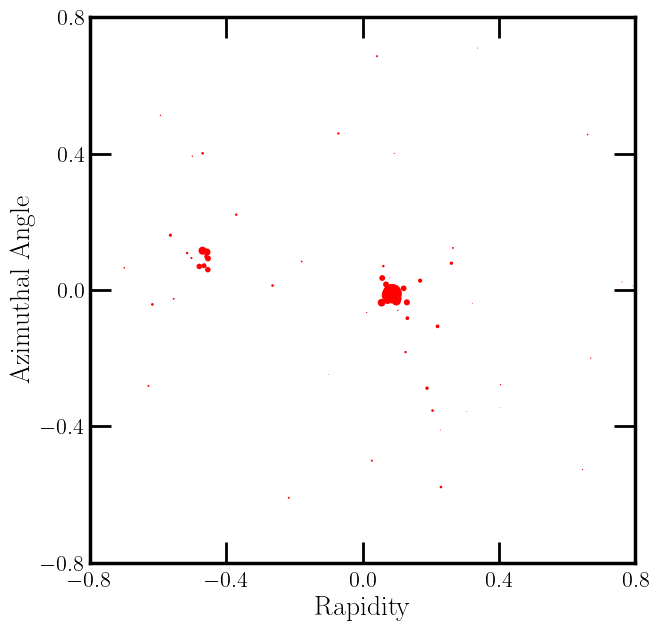

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [2]:
pad = 75 # Note that runtime is pad^2, memory is pad^4
dataset_name = "SPECTER_qcd_jets" # Can also be "SPECTER_top_jets"
cache_dir = "~/.ParticleLoader"

n_samples = 100
batch_size = 1 # Number of pairs to process in parallel, can probably be increased.

# Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
data = load(dataset_name, n_samples, cache_dir)[:n_samples, :pad]
data = center_and_normalize_zyphi(data)

# Show an event
fig, ax = newplot("full")
plot_event(ax, data[0], R = 0.8)


# Set up SPECTER

In [3]:
# Set up and compile SPECTER
specter = SPECTER(compile = True)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  5.619614362716675  seconds.
Compiling spectral representation functions ...
Compiling observables...
Observables compiled! Time taken:  51.09527134895325  seconds.
Compilation complete! Time taken:  51.09528684616089  seconds.


# Compute EMDs
Compute the EMDs between every pair of events, in parallel batches of `batch_size` events.

In [4]:
# Get list of pairwise indices
i_pairs, j_pairs = np.triu_indices(n_samples, k = 1)

# Initialize matrix to store pairwise EMDs
pairwise_emds = np.zeros((n_samples, n_samples))

# Compute batches
start_time = time.time()
for n in range(0, len(i_pairs), batch_size):

    print(f"Computing Batch {n}-{n+batch_size} of {len(i_pairs)} pairs. Elapsed Time: {time.time() - start_time :.3f} seconds")
    i_batch = i_pairs[n : n + batch_size]
    j_batch = j_pairs[n : n + batch_size]
    
    # Compute the pairwise EMDs
    emds = specter.spectralEMD(data[i_batch], data[j_batch])
    
    # Store the results
    pairwise_emds[i_batch, j_batch] = emds
    pairwise_emds[j_batch, i_batch] = emds

print(f"Done! Total Elapsed Time: {time.time() - start_time :.3f} seconds")

Computing Batch 0-1 of 4950 pairs. Elapsed Time: 0.000 seconds
Computing Batch 1-2 of 4950 pairs. Elapsed Time: 3.130 seconds
Computing Batch 2-3 of 4950 pairs. Elapsed Time: 3.135 seconds
Computing Batch 3-4 of 4950 pairs. Elapsed Time: 3.138 seconds
Computing Batch 4-5 of 4950 pairs. Elapsed Time: 3.142 seconds
Computing Batch 5-6 of 4950 pairs. Elapsed Time: 3.145 seconds
Computing Batch 6-7 of 4950 pairs. Elapsed Time: 3.148 seconds
Computing Batch 7-8 of 4950 pairs. Elapsed Time: 3.152 seconds
Computing Batch 8-9 of 4950 pairs. Elapsed Time: 3.159 seconds
Computing Batch 9-10 of 4950 pairs. Elapsed Time: 3.167 seconds
Computing Batch 10-11 of 4950 pairs. Elapsed Time: 3.178 seconds
Computing Batch 11-12 of 4950 pairs. Elapsed Time: 3.185 seconds
Computing Batch 12-13 of 4950 pairs. Elapsed Time: 3.194 seconds
Computing Batch 13-14 of 4950 pairs. Elapsed Time: 3.205 seconds
Computing Batch 14-15 of 4950 pairs. Elapsed Time: 3.214 seconds
Computing Batch 15-16 of 4950 pairs. Elapsed

Text(0, 0.5, 'Density')

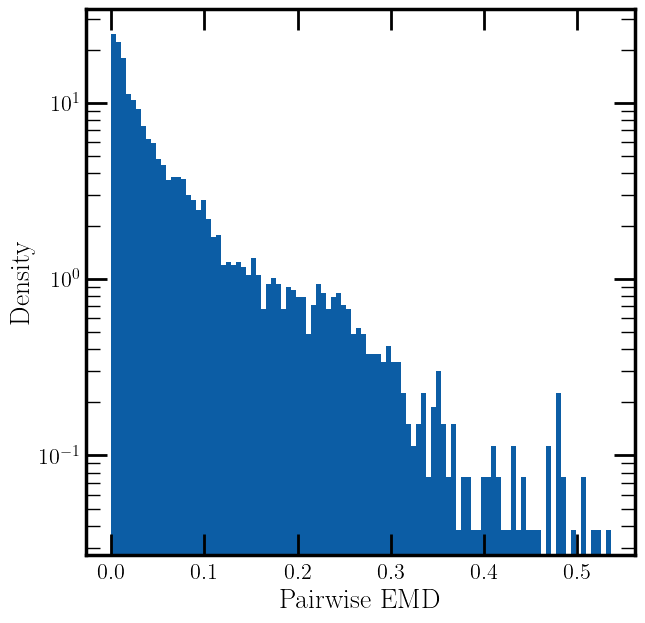

In [5]:
# Histogram the results (upper triangle only)
fig, ax = newplot("full")
plt.hist(pairwise_emds[np.triu_indices(n_samples, k = 1)], bins = 100, density=True)
plt.yscale("log")
plt.xlabel("Pairwise EMD")
plt.ylabel("Density")
